# **Fraud Detection Model: Internship Assessment**

This notebook aims to solve the business case of predicting fraudulent transactions for a financial company. The process will include data cleaning, exploratory data analysis, feature engineering, and building a high-performance machine learning model.


### **Importing Libraries**

In [36]:
%pip install --upgrade scikit-learn imbalanced-learn category-encoders xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
print("📦 importing required libraries...")

# importing core libraries
import numpy as np
import pandas as pd
import os
import joblib
import warnings
import math

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# importing scikit-learn preprocessing and model selection tools
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

# importing imbalanced-learn tools for handling imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# importing machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn import preprocessing

# importing evaluation metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

print("✅ all libraries imported successfully!")

📦 importing required libraries...
✅ all libraries imported successfully!


### **1. Loading the Dataset**

First, we'll import the necessary libraries for data manipulation and analysis, primarily `pandas`. We then load the dataset from the CSV file into a pandas DataFrame. A DataFrame is a 2D labeled data structure, similar to a spreadsheet, that will serve as our primary tool for handling the data.

In [2]:
import pandas as pd
import numpy as np

# Assuming your file is named 'fraud_data.csv' or similar
df = pd.read_csv('Fraud.csv')

***

### **2. Initial Data Inspection**

After loading the data, we perform a preliminary inspection to understand its basic properties. This involves:
* **`.head()`:** Viewing the first few rows to ensure the data has loaded correctly and to get a feel for the columns.
* **`.isnull().sum()`:** Checking for any missing values across all columns. This is a critical first step in the data cleaning process.
* **`.info()`:** Getting a concise summary of the DataFrame, including the data type of each column and the number of non-null values.

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


***

### **3. Checking the Target Variable Distribution**

This is one of the most important initial steps. We need to understand the distribution of our target variable, **`isFraud`**. For fraud detection, we expect the data to be highly imbalanced, meaning there will be far more legitimate transactions than fraudulent ones. Confirming this imbalance is crucial as it will heavily influence our modeling strategy and choice of evaluation metrics.

In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
classes=df['isFraud'].value_counts()
normal_share=classes[0]/df['isFraud'].count()*100
fraud_share=classes[1]/df['isFraud'].count()*100

### **3. Exploring Transaction Types**

Now we'll perform our first piece of Exploratory Data Analysis (EDA). A crucial step is to understand the relationship between the `type` of transaction and fraudulent activity. We will group the data by transaction type and sum the number of fraudulent transactions in each category. This will reveal which transaction methods are being exploited.

In [9]:
# Check the number of fraudulent transactions in each transaction type
print("--- Fraudulent Transactions by Type ---")
print(df.groupby('type')['isFraud'].sum())

--- Fraudulent Transactions by Type ---
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [10]:
print(f"Non-Fraudulent Transactions (Class 0): {classes[0]} ({normal_share:.3f}%)")
print(f"    Fraudulent Transactions (Class 1): {classes[1]} ({fraud_share:.3f}%)")

Non-Fraudulent Transactions (Class 0): 6354407 (99.871%)
    Fraudulent Transactions (Class 1): 8213 (0.129%)


### **4. Feature Engineering: Balance Errors**

Based on our understanding of the data, we can create new features that might be strong predictors of fraud. A common technique is to check for discrepancies in account balances. Theoretically, the final balance should be the initial balance minus the amount transferred. Any deviation from this could indicate suspicious activity.

We will calculate this balance error for both the originator and the destination accounts.

In [4]:
# Calculate the balance error for the originator account
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

# Calculate the balance error for the destination account
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Display the first 5 rows to see the new columns
print("--- DataFrame with New Error Balance Features ---")
df.head()

--- DataFrame with New Error Balance Features ---


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,11668.14


### **6. Visual EDA: Correlation Heatmap**

Now, we will dive into visual Exploratory Data Analysis (EDA) to uncover deeper insights. A correlation heatmap is an excellent tool to visualize the relationships between our numerical features. The color intensity indicates the strength of the correlation. This helps us identify features that are strongly correlated with our target variable `isFraud` and also to spot any potential multicollinearity between predictor variables.

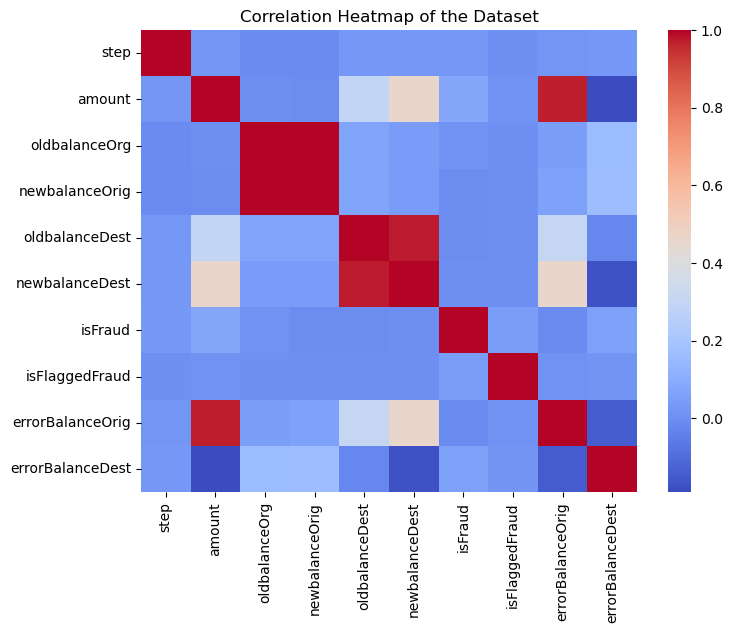

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Drop 'type' if exists, then select only numeric columns for correlation
df_for_corr = df.drop('type', axis=1, errors='ignore')
correlation_matrix = df_for_corr.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of the Dataset')
plt.show()


### **8. Visualizing the Class Imbalance**

While we have seen the exact numbers, a visual representation makes the class imbalance in our target variable, `isFraud`, much clearer. We will use a countplot to show the distribution. This starkly illustrates the challenge for our machine learning model: learning from a very small number of positive (fraudulent) examples.

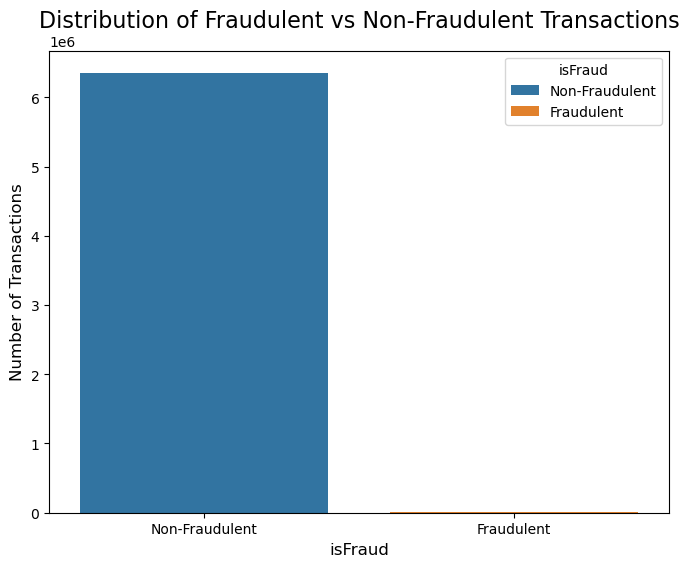

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# creating a bar plot for the number of fraudulent vs non-fraudulent transactions
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='isFraud', data=df, hue='isFraud')

plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions', fontsize=16)
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('isFraud', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

# getting the legend object to update the labels
new_labels = ['Non-Fraudulent', 'Fraudulent']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)

plt.show()

### **9. Analyzing Transaction Amount Distribution**

Here, we analyze the `amount` feature. We will plot the distribution of transaction amounts, separating them by whether they are fraudulent or not. This can help us understand if fraudulent transactions tend to involve larger or smaller amounts compared to legitimate ones. Due to the high number of transactions and potential for outliers, we will focus on a subset of the data for clearer visualization.

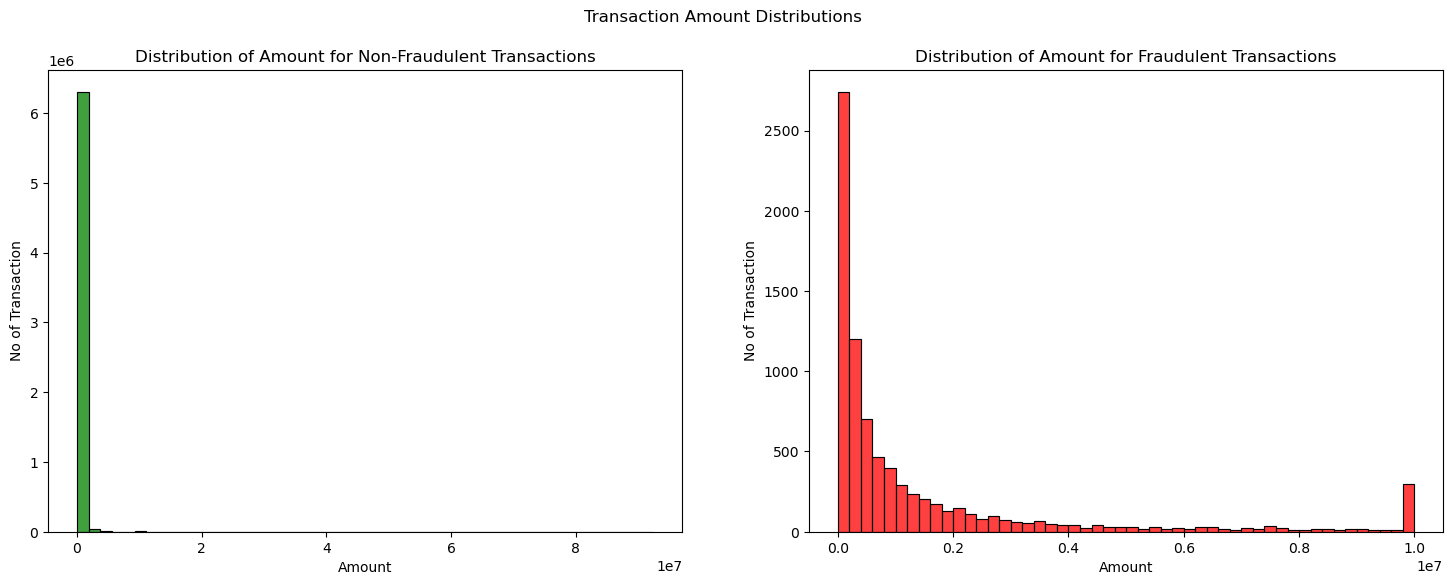

In [93]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot the distribution of transaction amounts for non-fraudulent transactions
sns.histplot(df[df['isFraud'] == 0]['amount'], bins=50, ax=ax1, color='g')
ax1.set_title('Distribution of Amount for Non-Fraudulent Transactions')
ax1.set_xlabel('Amount')
ax1.set_ylabel('No of Transaction')

# Plot the distribution of transaction amounts for fraudulent transactions
sns.histplot(df[df['isFraud'] == 1]['amount'], bins=50, ax=ax2, color='r')
ax2.set_title('Distribution of Amount for Fraudulent Transactions')
ax2.set_xlabel('Amount')
ax2.set_ylabel('No of Transaction')

plt.suptitle('Transaction Amount Distributions')
plt.show()

### **10. Skewness and Outliers in Transaction Amount**
We explicitly check for skewness and potential outliers in the Amount column, as these can affect the performance of certain machine learning models.

Skewness of 'Amount': 30.9939


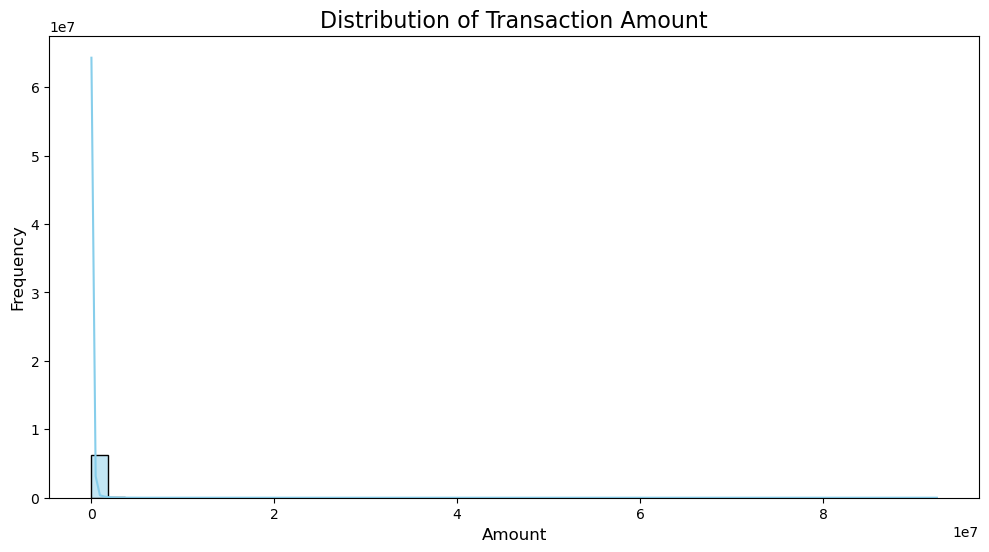

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot color (you can change it if you like)
plot_color = "skyblue"

# calculate skewness
skew_val = df['amount'].skew()
print(f"Skewness of 'Amount': {skew_val:.4f}")

# plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['amount'], bins=50, kde=True, color=plot_color)
plt.title('Distribution of Transaction Amount', fontsize=16)
plt.xlabel('Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


In [16]:
numerical_cols = ['amount']

In [17]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def udf_plot_boxplots(df, num_cols, cat_col=None, cols=3, figsize=(15, 8)):
    """
    Plots boxplots for numerical columns, with an option to group by a categorical column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    num_cols (list): List of numerical column names to plot.
    cat_col (str, optional): The name of the categorical column to group by. Defaults to None.
    cols (int): Number of columns for subplots.
    figsize (tuple): Figure size.
    """
    # Calculate the number of rows needed for subplots
    rows = math.ceil(len(num_cols) / cols)

    # Create the figure
    plt.figure(figsize=figsize)

    for i, col in enumerate(num_cols):
        # Create a subplot for each column
        ax = plt.subplot(rows, cols, i + 1)
        
        # If a categorical column is provided, create comparative boxplots
        if cat_col:
            sns.boxplot(x=cat_col, y=col, data=df, ax=ax)
            ax.set_title(f'{col} by {cat_col}')
        # Otherwise, create a single boxplot
        else:
            sns.boxplot(y=df[col], ax=ax)
            ax.set_title(f'{col}')

    # Adjust layout to prevent overlap and display the plot
    plt.tight_layout()
    plt.show()


### **11. Data Preprocessing and Feature Engineering**
In this section, we prepare the data for modeling. This involves dropping unnecessary features, splitting the data into training and test sets, and applying transformations to handle skewed distributions.

In [5]:
# Drop the nameOrig and nameDest columns from the DataFrame
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Display the first 5 rows to confirm the columns are gone
print("--- DataFrame After Dropping Columns ---")
df.head()

--- DataFrame After Dropping Columns ---


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,9839.64
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,1864.28
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0.0,181.00
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,21363.00
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,11668.14


### **11.1. Rearranging Columns**
For convenience and clarity, we are moving the target variable, isFraud, to be the last column in the dataframe.

In [6]:
# Reordering columns to have the target 'Class' at the end
df = df[[col for col in df.columns if col != 'isFraud'] + ['isFraud']]
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,0,0.0,181.00,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,0,0.0,21363.00,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,0


### **11.2. Splitting the Data into Training and Test Sets**
We are splitting the dataset into features (X) and the target (y). Then, we perform a train-test split to create our training and validation sets.



In [7]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

A stratified split is crucial here to ensure that the proportion of fraudulent transactions is the same in both the training and test sets, which is vital for a highly imbalanced dataset.



In [8]:
# stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **11.2.1. Verifying the Stratified Split**
We are preserving X_test & y_test for the final model evaluation. It's important to confirm that the small number of fraud cases has been distributed correctly between the sets.

In [9]:
print(f"Total Frauds in entire dataset: {np.sum(y)}")
print(f"Frauds in Training Set:         {np.sum(y_train)}")
print(f"Frauds in Test Set:             {np.sum(y_test)}")

Total Frauds in entire dataset: 8213
Frauds in Training Set:         6570
Frauds in Test Set:             1643


### **11.3. Feature Transformation and Scaling**
Many machine learning models perform better when features are on a similar scale and are normally distributed. We will now address the skewness in the Amount feature.

### **11.3.1. Analyzing Skewness in 'Amount**
We plot the distribution of the Amount feature within the training set.

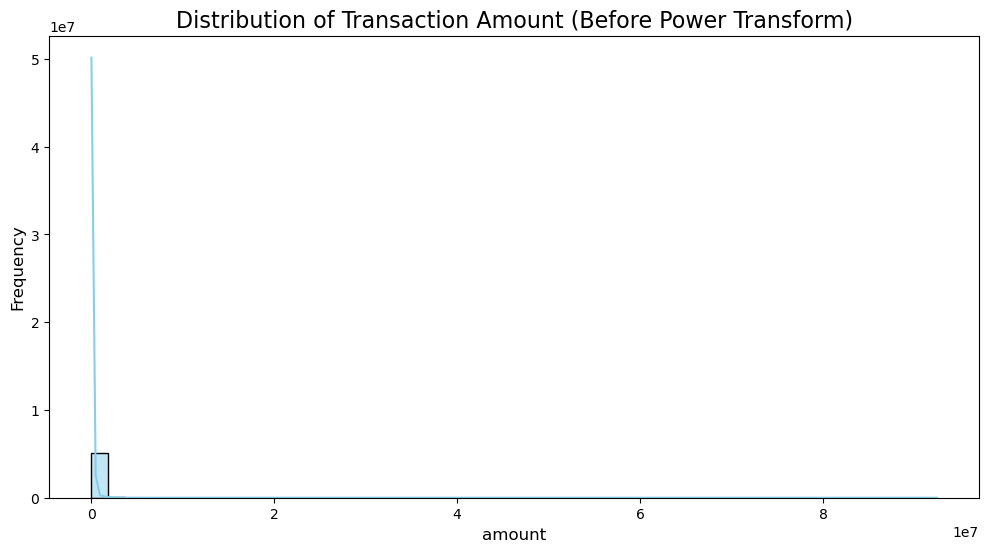

In [23]:
# checking skewness for `Amount` column after Scaling

plt.figure(figsize=(12, 6))
sns.histplot(X_train['amount'], bins=50, kde=True, color=plot_color)
plt.title('Distribution of Transaction Amount (Before Power Transform)', fontsize=16)
plt.xlabel('amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

#### Observations

 ##### The distribution of the scaled 'amount' is still heavily right-skewed."

###### To correct this, we will use a PowerTransformer. This transformation is applied after the train-test split to prevent data leakage from the test set into the training process. The transformer will be fit on the training data and then used to transform both the training and test data.

### **11.3.2. Applying Power Transformer to the Amount Feature**
 ##### We use the PowerTransformer from scikit-learn to make the distribution of the Amount feature more Gaussian-like.

In [24]:
from sklearn import preprocessing

amount_train = X_train['amount'].values.reshape(-1, 1)
amount_test = X_test['amount'].values.reshape(-1, 1)

pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True, copy=False)

# fitting and transform the training data
X_train['amount'] = pt.fit_transform(amount_train)

# transofmring the test data
X_test['amount'] = pt.transform(amount_test)

print(f"\nApplied PowerTransformer to the 'amount' column.\n")


Applied PowerTransformer to the 'amount' column.



### **11.3.3. Verifying the Transformation**
##### We now plot the histogram of the Amount column again to see the result of the transformation.

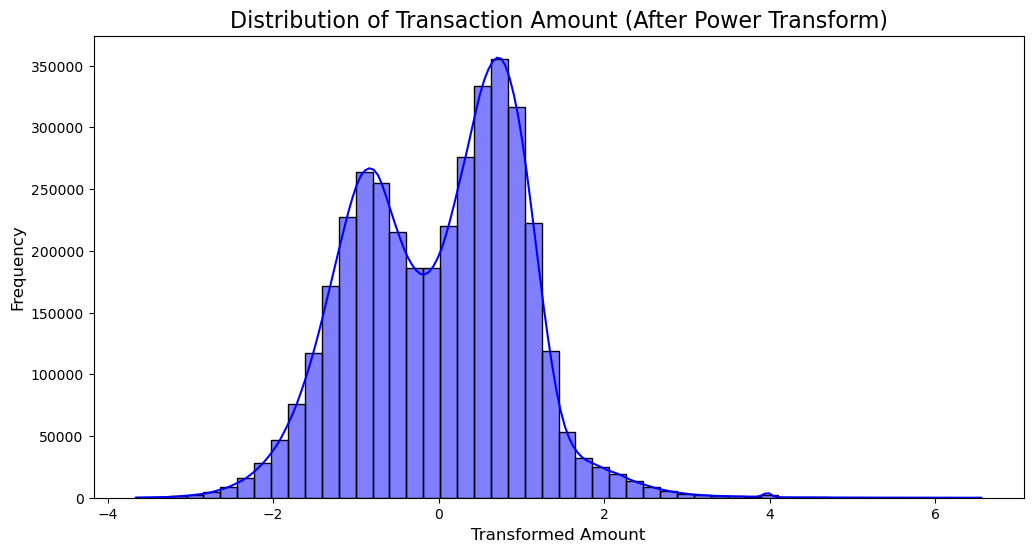

The distribution is now much closer to a normal (Gaussian) distribution.


In [26]:
# plotting the histogram of the transformed variable to see the result

plt.figure(figsize=(12, 6))
plot_color = 'blue' 
sns.histplot(X_train['amount'], bins=50, kde=True, color=plot_color)
plt.title('Distribution of Transaction Amount (After Power Transform)', fontsize=16)
plt.xlabel('Transformed Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
print("The distribution is now much closer to a normal (Gaussian) distribution.")

In [27]:
X_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
5378122,376,CASH_OUT,-0.073305,537.52,0.00,6989545.61,7043234.82,0,53151.69,0.000000e+00
468094,19,CASH_OUT,0.970152,10246.00,0.00,215865.24,500037.59,0,273926.35,-5.820766e-11
2872745,227,CASH_OUT,-0.634140,16743.00,0.00,0.00,18915.18,0,2172.18,0.000000e+00
2232908,186,CASH_OUT,0.957908,1594.00,0.00,78918.12,358061.30,0,277549.18,0.000000e+00
4536553,326,CASH_OUT,0.101157,159107.00,86550.23,0.00,72556.77,0,0.00,0.000000e+00


In [28]:
X_test.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
3006538,232,CASH_IN,1.056655,20764.0,342819.06,40081.74,0.00,0,644110.12,362136.80
5475721,379,CASH_OUT,0.556092,0.0,0.00,1495528.64,1647701.75,0,152173.10,-0.01
792057,40,CASH_OUT,1.091818,0.0,0.00,678463.60,1017156.83,0,338693.24,0.01
1866630,164,PAYMENT,-0.638551,987.0,0.00,0.00,0.00,0,17764.17,18751.17
278210,15,PAYMENT,-1.306358,161.0,0.00,0.00,0.00,0,4338.75,4499.75


## **12. Modeling on Imbalanced Data**

In this section, we will build, train, and evaluate several machine learning models directly on the original, imbalanced training data. The purpose is to establish a baseline performance for each algorithm. We will use GridSearchCV to find the best hyperparameters for each model, using the Area Under the Precision-Recall Curve (AUPRC) as our primary scoring metric.

#### **12.1. Model Building Setup**
First, we define the components that will be used across all our modeling experiments.

#### **12.1.2. Cross-Validation Strategy**
We are using StratifiedKFold for our cross-validation. this is essential to ensure that each fold has the same percentage of fraudulent transactions as the complete training set, which is critical for reliable evaluation on imbalanced data.

In [29]:
from sklearn import linear_model

num_C = [0.001, 0.01, 0.1, 1]  #--> list of values
cv_num = 5   #--> number of cross-validation folds

In [30]:
# we use StratifiedKFold to maintain the same class distribution in each fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# defining the scoring metric, focusing on AUPRC
scoring = 'average_precision'

#### **12.1.2. Model Caching and Helper Function**
To avoid re-running computationally expensive grid searches, we first create a directory to store trained models and then define our helper function, run_or_load_grid_search, which handles the training and caching logic.

In [31]:
import os
import joblib

WORKING_MODELS_PATH = os.path.join(os.getcwd(), "models")

INPUT_MODELS_PATH = os.path.join(os.getcwd(), "models")

def get_model_path(model_name: str) -> str:
    """
    Create full model path dynamically.
    
    Parameters:
        model_name (str): e.g. 'lr_imbalanced_gs.pkl'
    
    Returns:
        str: full path like 'C:/your/project/path/models/lr_imbalanced_gs.pkl'
    """
    return os.path.join(WORKING_MODELS_PATH, model_name)

# Create the models directory for the current session.
os.makedirs(WORKING_MODELS_PATH, exist_ok=True)

print(f"📁 Models trained in this session will be saved to: {WORKING_MODELS_PATH}")
print(f"📁 Previously saved models will be loaded from: {INPUT_MODELS_PATH}")


📁 Models trained in this session will be saved to: C:\Users\hp\Fraud_Detection\models
📁 Previously saved models will be loaded from: C:\Users\hp\Fraud_Detection\models


In [32]:
from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os
import joblib

def run_or_load_random_search(estimator,
                              param_dist,
                              X_train,
                              y_train,
                              n_iter, # Added n_iter parameter
                              cv_strategy=3,
                              scoring_metric="f1",
                              model_path="models/random_model.pkl",
                              n_jobs=1,
                              max_samples=100000,
                              force_retrain=False):
    """
    Runs RandomizedSearchCV safely on a subset of the dataset.
    Loads the saved model if available.
    """
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    if not force_retrain and os.path.exists(model_path):
        print(f"✅ Found and loading model from:\n    {os.path.abspath(model_path)}")
        return joblib.load(model_path)

    if force_retrain:
        print(f"🔄 Forcing retraining for {os.path.abspath(model_path)} ...")
    else:
        print(f"🚀 No pre-trained model found. Running RandomizedSearchCV...")

    if max_samples and len(X_train) > max_samples:
        print(f"⚡ Using subset of {max_samples} rows for search (from {len(X_train)})")
        X_train_small, y_train_small = X_train[:max_samples], y_train[:max_samples]
    else:
        X_train_small, y_train_small = X_train, y_train
        
    # Using RandomizedSearchCV instead of GridSearchCV
    random_search_object = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist, # Changed parameter name
        n_iter=n_iter, # Number of iterations to run
        scoring=scoring_metric,
        cv=cv_strategy,
        verbose=2,
        n_jobs=n_jobs,
        random_state=42 # Add random_state for reproducibility
    )
    
    random_search_object.fit(X_train_small, y_train_small)

    abs_path = os.path.abspath(model_path)
    print(f"💾 Saving newly trained model to:\n    {abs_path}")
    joblib.dump(random_search_object, abs_path)

    return random_search_object


#### **12.1.3. Importing Model Classes**
We import all the necessary model classes from scikit-learn and XGBoost.

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

#### **12.2. Logistic Regression**

We are training a Logistic Regression model. The model is placed within a Pipeline to ensure that data scaling occurs correctly within each cross-validation fold. We use class_weight='balanced' as a built-in method to handle imbalance.

In [16]:
# --- Preprocessing Pipeline (same as before) ---
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Parameter grid (same as before)
num_C = np.logspace(-2, 2, 5)
lr_param_grid = [
    {'lr__solver': ['liblinear'], 'lr__penalty': ['l1', 'l2'], 'lr__C': num_C},
    {'lr__solver': ['lbfgs'], 'lr__penalty': ['l2'], 'lr__C': num_C},
]

# CV and Scoring (same as before)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = "average_precision"

lr_model_path = get_model_path('lr_imbalanced_random_search.pkl')

lr_random_search = run_or_load_random_search(
    estimator=pipeline_lr,
    param_dist=lr_param_grid, # Note: parameter is renamed to param_dist
    X_train=X_train,
    y_train=y_train,
    n_iter=10, # We will only test 10 random combinations instead of all 15
    cv_strategy=cv_strategy,
    scoring_metric=scoring,
    model_path=lr_model_path,
    n_jobs=1
)

print("\n✅ Evaluation Results (Logistic Regression - Randomized Search):")
print(f"Best AUPRC Score: {lr_random_search.best_score_:.4f}")
print(f"Optimum Hyperparameters: {lr_random_search.best_params_}")
print(f"Model saved at: {os.path.abspath(lr_model_path)}")

✅ Found and loading model from:
    C:\Users\hp\Fraud_Detection\models\lr_imbalanced_random_search.pkl

✅ Evaluation Results (Logistic Regression - Randomized Search):
Best AUPRC Score: 0.8407
Optimum Hyperparameters: {'lr__solver': 'liblinear', 'lr__penalty': 'l1', 'lr__C': np.float64(1.0)}
Model saved at: C:\Users\hp\Fraud_Detection\models\lr_imbalanced_random_search.pkl


In [17]:
# ==============================================================================
# SECTION 1: IMPORTS
# ==============================================================================
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import os

# ==============================================================================
# SECTION 2: TRAIN XGBOOST (FINAL MODEL)
# ==============================================================================
print("\n--- Setting up XGBoost Model Training ---")

# --- Handling Class Imbalance with 'scale_pos_weight' ---
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Fraud ratio calculated. Using scale_pos_weight: {fraud_ratio:.2f}")

# --- Ensure 'models/' folder exists ---
os.makedirs("models", exist_ok=True)

# --- XGBoost Pipeline Definition ---
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=fraud_ratio,  # Crucial for imbalance
        random_state=42
    ))
])

# --- Parameter Grid for Randomized Search ---
xgb_param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0]
}

# --- Calling the Randomized Search Function ---
xgb_model_path = "models/xgb_random_search.pkl"

xgb_search = run_or_load_random_search(
    estimator=pipeline_xgb,
    param_dist=xgb_param_grid,
    X_train=X_train,
    y_train=y_train,
    n_iter=25,
    scoring_metric="average_precision",
    model_path=xgb_model_path
)

# --- Displaying the Results ---
print("\n✅ XGBoost Results:")
print(f"Best AUPRC Score: {xgb_search.best_score_:.4f}")
print(f"Optimum Hyperparameters: {xgb_search.best_params_}")
print(f"Model saved at: {os.path.abspath(xgb_model_path)}")



--- Setting up XGBoost Model Training ---
Fraud ratio calculated. Using scale_pos_weight: 773.75
✅ Found and loading model from:
    C:\Users\hp\Fraud_Detection\models\xgb_random_search.pkl

✅ XGBoost Results:
Best AUPRC Score: 0.9901
Optimum Hyperparameters: {'xgb__subsample': 0.7, 'xgb__n_estimators': 100, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.7}
Model saved at: C:\Users\hp\Fraud_Detection\models\xgb_random_search.pkl


Train size: (3817572, 10), Val size: (1272524, 10), Test size: (1272524, 10)

Classification Report (Test):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000   1270882
           1      0.908     0.984     0.944      1642

    accuracy                          1.000   1272524
   macro avg      0.954     0.992     0.972   1272524
weighted avg      1.000     1.000     1.000   1272524

Test AUPRC: 0.993513


<Figure size 1000x600 with 0 Axes>

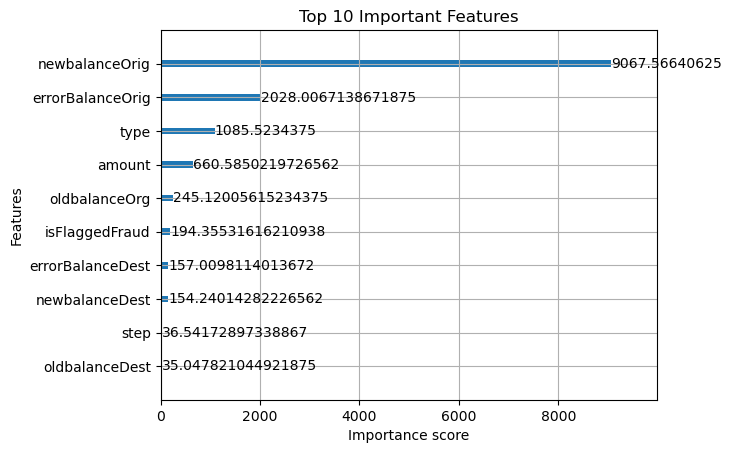

In [34]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Convert categorical columns to pandas "category" dtype
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].astype("category")

# ===========================
# Subset control
# ===========================
subset_fraction = 1.0  # use 100% of data

if subset_fraction < 1.0:
    # Take only a subset
    X_subset, _, y_subset, _ = train_test_split(
        X, y, train_size=subset_fraction, stratify=y, random_state=42
    )
else:
    # Use full dataset
    X_subset, y_subset = X, y


# Split train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_subset, y_subset, train_size=0.6, stratify=y_subset, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

# ===========================
# Train model
# ===========================
xgb_clf = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=0.8,
    scale_pos_weight=20, 
    eval_metric="aucpr",
    tree_method="hist",   
    enable_categorical=True, 
    random_state=42
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# ===========================
# Evaluation
# ===========================
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, digits=3))

test_auprc = average_precision_score(y_test, y_proba)
print(f"Test AUPRC: {test_auprc:.6f}")

# ===========================
# Feature Importance
# ===========================
plt.figure(figsize=(10,6))
plot_importance(xgb_clf, importance_type="gain", max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()


### **12.3. Summary of Baseline Model Performance**
Now that all models have been trained on the imbalanced data, we will compile the results into a summary table to easily compare their cross-    validated AUPRC scores.

In [35]:
import pandas as pd

results_imbalanced = {
    "Logistic Regression": lr_random_search,
    "XGBoost": xgb_search
}

# 2. Create an empty list to store the summary data.
summary_data = []

# 3. Loop through your results and extract the key information.
for name, model_search_object in results_imbalanced.items():
    summary_data.append({
        "Model": name,
        "Best AUPRC Score": model_search_object.best_score_,
        "Best Parameters": model_search_object.best_params_
    })

# 4. Create a pandas DataFrame from the summary data.
summary_df_imbalanced = pd.DataFrame(summary_data)

# 5. Sort the DataFrame by score to see the best model on top.
summary_df_imbalanced = summary_df_imbalanced.sort_values(by="Best AUPRC Score", ascending=False)

# 6. Display the final summary table.
print("\nSummary of Model Performance")
display(summary_df_imbalanced)


Summary of Model Performance


,Model,Best AUPRC Score,Best Parameters
1,XGBoost,0.990066,"{'xgb__subsample': 0.7, 'xgb__n_estimators': 1..."
0,Logistic Regression,0.840666,"{'lr__solver': 'liblinear', 'lr__penalty': 'l1..."


### **12.3. Evaluating the Best Imbalanced Model on Test Data**
The summary table shows that the XGBoost classifier achieved the highest cross-validated AUPRC score. We will now take this best-performing model, train it on the full training dataset, and evaluate its performance on the unseen test set.

In [71]:
print(f"\nBest model found: {xgb_search.best_estimator_}")
print(f"\nOptimum Hyperparameters: {xgb_search.best_params_}\n")


Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'errorBalanceOrig',
       'errorBalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['type'], dtype='object'))])),
                ('xgb',
                 XGBClassifi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
    

#### **12.3.1. Final Fit and Prediction**
We are initializing the model with its optimal hyperparameters and fitting it to the entire training set. then we are predicting probabilities on the test set

In [72]:
clf = xgb_search.best_estimator_  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train)

# get the probabilities of the positive class (fraud = 1) for test dataset
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# auprc on test set
auprc_score = average_precision_score(y_test, y_pred_proba)

print(f'\nAUPRC Score on X_test (Imbalanced Model): {auprc_score}\n') #print the evaluation score on the X_test by choosing the best evaluation metric


AUPRC Score on X_test (Imbalanced Model): 0.9930069849965156



### **12.3.2. Finding the Optimal Classification Threshold**
To generate a classification report, we need to convert the predicted probabilities into binary class labels (0 or 1). We find an optimal threshold by maximizing the F1-score, which provides a good balance between precision and recall.

In [73]:
# Finding the optimal threshold

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

best_f1_score = np.max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'\nBest F1 Score: {best_f1_score:.4f}')
print(f'Optimal Threshold (maximizing F1-score): {best_threshold:.4f}\n')


Best F1 Score: 0.9570
Optimal Threshold (maximizing F1-score): 0.9964



### **12.3.3. Classification Report**
We are now evaluating the model's performance on the test set using the optimal threshold found above.



In [74]:
# Evaluating the model using the optimal threshold
y_pred = (y_pred_proba >= best_threshold).astype(int)

print("\nClassification Report (using Optimal Threshold):\n")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))


Classification Report (using Optimal Threshold):

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1270882
       Fraud       0.95      0.96      0.96      1642

    accuracy                           1.00   1272524
   macro avg       0.98      0.98      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524



### **12.3.4. Feature Importance Analysis**
Finally, we investigate the feature importances from our best model (XGBoost) to understand which of the PCA-transformed features were most influential in detecting fraud. This will not give much explanation on the already transformed dataset, but it will help us in understanding if the dataset is not PCA transformed.

✅ Model pipeline loaded successfully from models/xgb_random_search.pkl

--- Top 5 Most Important Features ---
                 Feature  Importance
0  num__errorBalanceOrig    0.348207
1    num__newbalanceOrig    0.290253
2      cat__type_PAYMENT    0.123024
3      cat__type_CASH_IN    0.067270
4     cat__type_CASH_OUT    0.045312


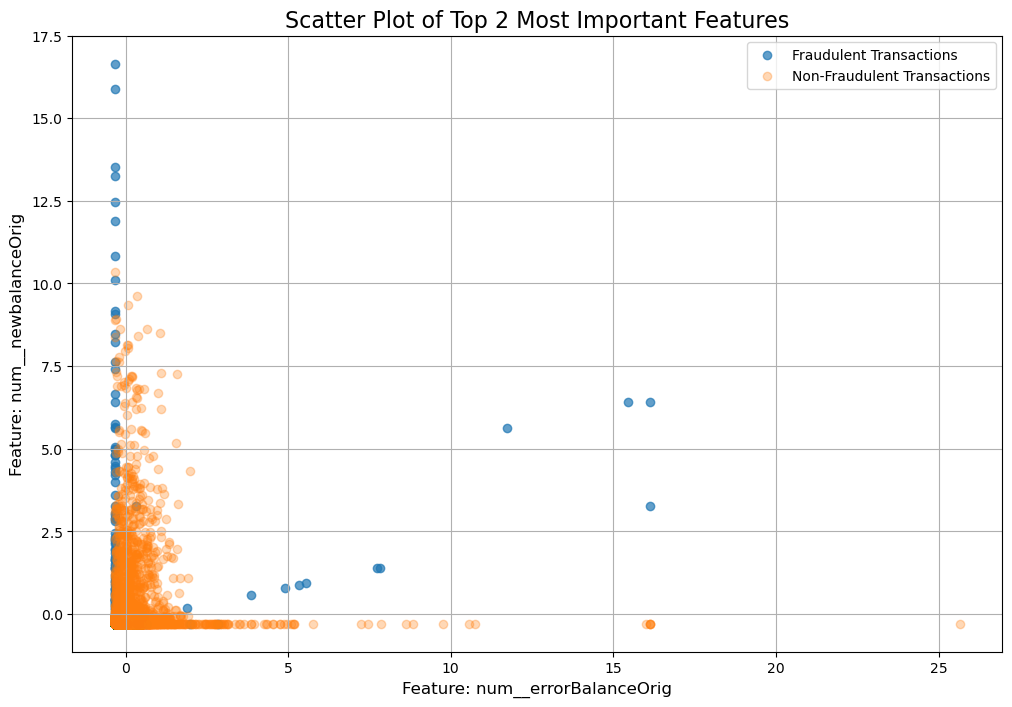

In [80]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model_path = 'models/xgb_random_search.pkl'
tuned_model_search_object = joblib.load(model_path)
best_pipeline = tuned_model_search_object.best_estimator_
print(f"✅ Model pipeline loaded successfully from {model_path}")

preprocessor = best_pipeline.named_steps['preprocessor']
xgb_model = best_pipeline.named_steps['xgb']

feature_names = preprocessor.get_feature_names_out()

importances = xgb_model.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

print("\n--- Top 5 Most Important Features ---")
top_features_df = pd.DataFrame({
    'Feature': feature_names[sorted_indices][:5],
    'Importance': importances[sorted_indices][:5]
})
print(top_features_df)


# 3. PREPARE DATA FOR PLOTTING
# -----------------------------
top_var_index = sorted_indices[0]
second_top_var_index = sorted_indices[1]
top_feature_name = feature_names[top_var_index]
second_top_feature_name = feature_names[second_top_var_index]

# NOTE: We need to use the TRANSFORMED data for plotting
X_train_transformed = preprocessor.transform(X_train)
y_train_numpy = y_train.to_numpy() # Ensure y_train is a numpy array

X_train_1 = X_train_transformed[np.where(y_train_numpy == 1)]
X_train_0 = X_train_transformed[np.where(y_train_numpy == 0)]
np.random.shuffle(X_train_0)


# 4. CREATE THE SCATTER PLOT
# ---------------------------
plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index],
            label='Fraudulent Transactions', alpha=0.7)
plt.scatter(X_train_0[:len(X_train_1), top_var_index], X_train_0[:len(X_train_1), second_top_var_index],
            label='Non-Fraudulent Transactions', alpha=0.3)
plt.title('Scatter Plot of Top 2 Most Important Features', fontsize=16)
plt.xlabel(f'Feature: {top_feature_name}', fontsize=12)
plt.ylabel(f'Feature: {second_top_feature_name}', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## **13. Modeling with Balanced Classes**

#### Imbalance Handling:

##### oversampling techniques: Random Oversampling (ROS), SMOTE and ADASYN

### **13.1. Setup for Balanced Modeling**

We will use the Pipeline from the imblearn library. This is crucial as it ensures that the oversampling technique is applied only to the training data within each cross-validation fold, preventing data leakage and an overly optimistic evaluation.

### **13.2. Balancing with Random Oversampling**

In [21]:
# Import necessary libraries if not already imported
from imblearn import over_sampling
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

print("\nTraining XGBoost with Random Oversampling")

numeric_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


ros_xgb_pipeline = ImbPipeline([
    ('ros', over_sampling.RandomOverSampler(random_state=42)),
    ('preprocessor', preprocessor), # This step converts all data to numeric
    ('xgb', XGBClassifier(random_state=42, eval_metric='aucpr', use_label_encoder=False))
])

# Define the hyperparameter grid for XGBoost (note the 'xgb__' prefix is still correct)
ros_xgb_param_grid = {
    'xgb__n_estimators': [150, 200],
    'xgb__max_depth': [5, 7, 9],
    'xgb__learning_rate': [0.1, 0.05],
    'xgb__subsample': [0.8, 1.0]
}

# Define the path to save the model
ros_xgb_model_path = 'models/ros_xgb_rs.pkl'

# Run the random search using your helper function
ros_xgb_grid_search = run_or_load_random_search(
    estimator=ros_xgb_pipeline,
    param_dist=ros_xgb_param_grid,
    X_train=X_train,
    y_train=y_train,
    n_iter=15, # Reduced n_iter for speed with a more complex pipeline
    cv_strategy=cv_strategy,
    scoring_metric=scoring,
    model_path=ros_xgb_model_path
)

# Print the evaluation result
print(f"\nBest AUPRC Score: {ros_xgb_grid_search.best_score_:.4f}")

# Print the optimum value of hyperparameters
print(f"Optimum Hyperparameters: {ros_xgb_grid_search.best_params_}\n")


Training XGBoost with Random Oversampling
🚀 No pre-trained model found. Running RandomizedSearchCV...
⚡ Using subset of 100000 rows for search (from 5090096)
Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:04:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   7.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:04:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   6.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   3.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   5.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   9.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:05:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   9.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   7.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   6.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   6.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   6.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:06:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   3.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   9.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   8.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   8.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   4.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   3.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   4.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   3.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:08:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


💾 Saving newly trained model to:
    C:\Users\hp\Fraud_Detection\models\ros_xgb_rs.pkl

Best AUPRC Score: 0.9820
Optimum Hyperparameters: {'xgb__subsample': 1.0, 'xgb__n_estimators': 200, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05}



### **13.3. Balancing with SMOTE**

In [23]:
# Import necessary libraries if not already imported
from imblearn import over_sampling
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

print("\nTraining XGBoost with SMOTE")

numeric_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


smote_xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor), # 1. Preprocess the data first
    ('smote', over_sampling.SMOTE(random_state=42)), # 2. Then apply SMOTE
    ('xgb', XGBClassifier(random_state=42, eval_metric='aucpr', use_label_encoder=False))
])

xgb_param_grid = {
    'xgb__n_estimators': [150, 200],
    'xgb__max_depth': [5, 7, 9],
    'xgb__learning_rate': [0.1, 0.05],
    'xgb__subsample': [0.8, 1.0]
}

smote_xgb_model_path = 'models/smote_xgb_rs.pkl'

smote_xgb_search = run_or_load_random_search(
    estimator=smote_xgb_pipeline,
    param_dist=xgb_param_grid,
    X_train=X_train,
    y_train=y_train,
    n_iter=15,
    cv_strategy=cv_strategy,
    scoring_metric=scoring,
    model_path=smote_xgb_model_path
)

# Print the evaluation result
print(f"\nBest AUPRC Score: {smote_xgb_search.best_score_:.4f}")

# Print the optimum value of hyperparameters
print(f"Optimum Hyperparameters: {smote_xgb_search.best_params_}\n")


Training XGBoost with SMOTE
🚀 No pre-trained model found. Running RandomizedSearchCV...
⚡ Using subset of 100000 rows for search (from 5090096)
Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   5.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   9.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   9.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:21:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=  10.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:21:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   8.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:21:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   7.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:21:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   5.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:21:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   6.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:21:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   7.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:21:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   6.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=  11.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   4.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   3.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   0.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   0.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   3.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:22:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   5.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   7.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   8.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   5.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   5.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   7.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:23:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   5.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   5.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:24:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


💾 Saving newly trained model to:
    C:\Users\hp\Fraud_Detection\models\smote_xgb_rs.pkl

Best AUPRC Score: 0.9823
Optimum Hyperparameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 150, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1}



### **13.4. Balancing with ADASYN**

In [24]:
# Import necessary libraries if not already imported
from imblearn import over_sampling
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

print("\nTraining XGBoost with ADASYN")

# Define the preprocessor that will be used inside the pipeline
numeric_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

adasyn_xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('adasyn', over_sampling.ADASYN(random_state=42)), # Use ADASYN for balancing
    ('xgb', XGBClassifier(random_state=42, eval_metric='aucpr', use_label_encoder=False))
])

# Define the hyperparameter grid for XGBoost
xgb_param_grid = {
    'xgb__n_estimators': [150, 200],
    'xgb__max_depth': [5, 7, 9],
    'xgb__learning_rate': [0.1, 0.05],
    'xgb__subsample': [0.8, 1.0]
}

# Define the path to save the new model
adasyn_xgb_model_path = 'models/adasyn_xgb_rs.pkl'

# Run the random search using your helper function
adasyn_xgb_search = run_or_load_random_search(
    estimator=adasyn_xgb_pipeline,
    param_dist=xgb_param_grid,
    X_train=X_train,
    y_train=y_train,
    n_iter=15,
    cv_strategy=cv_strategy,
    scoring_metric=scoring,
    model_path=adasyn_xgb_model_path
)

# Print the evaluation result
print(f"\nBest AUPRC Score: {adasyn_xgb_search.best_score_:.4f}")

# Print the optimum value of hyperparameters
print(f"Optimum Hyperparameters: {adasyn_xgb_search.best_params_}\n")


Training XGBoost with ADASYN
🚀 No pre-trained model found. Running RandomizedSearchCV...
⚡ Using subset of 100000 rows for search (from 5090096)
Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   9.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   7.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   3.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:33:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   2.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   9.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  12.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=  11.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:34:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=  10.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   7.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   7.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:35:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=1.0; total time=   7.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   6.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   9.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   7.3s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=1.0; total time=   2.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:36:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   6.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   7.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   8.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   9.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.8; total time=   8.0s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   7.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   5.1s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.5s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.9s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.4s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.2s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:37:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:38:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:38:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.6s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:38:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.8s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:38:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:38:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.8; total time=   1.7s


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:38:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


💾 Saving newly trained model to:
    C:\Users\hp\Fraud_Detection\models\adasyn_xgb_rs.pkl

Best AUPRC Score: 0.9804
Optimum Hyperparameters: {'xgb__subsample': 1.0, 'xgb__n_estimators': 150, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1}



### **14. Model Evaluation and Final Selection**

 ##### **14.1 Overall Performance Summary**

In [37]:
import pandas as pd

all_results = {
    # Imbalanced Data
    "Logistic Regression (Imbalanced)": lr_random_search,
    "XGBoost (Imbalanced)": xgb_search,

    # RandomOverSampler (ROS)
    "XGBoost (ROS)": ros_xgb_grid_search,

    # SMOTE
    "XGBoost (SMOTE)": smote_xgb_search,

    # ADASYN
    "XGBoost (ADASYN)": adasyn_xgb_search,
}

# 2. Create an empty list to store the summary data.
summary_list = []

# 3. Loop through your results and extract the key information.
for name, model_search_object in all_results.items():
    summary_list.append({
        "Model": name,
        "Best AUPRC Score": model_search_object.best_score_,
        "Best Parameters": model_search_object.best_params_
    })

# 4. Create a pandas DataFrame from the summary data.
final_summary_df = pd.DataFrame(summary_list)

# 5. Sort the DataFrame by score to see the best model on top.
final_summary_df = final_summary_df.sort_values(by="Best AUPRC Score", ascending=False)

# 6. Display the final summary table.
print("\n--- Final Summary of All Model Performances ---")
display(final_summary_df)


--- Final Summary of All Model Performances ---


,Model,Best AUPRC Score,Best Parameters
1,XGBoost (Imbalanced),0.990066,"{'xgb__subsample': 0.7, 'xgb__n_estimators': 1..."
3,XGBoost (SMOTE),0.982277,"{'xgb__subsample': 0.8, 'xgb__n_estimators': 1..."
2,XGBoost (ROS),0.981973,"{'xgb__subsample': 1.0, 'xgb__n_estimators': 2..."
4,XGBoost (ADASYN),0.980421,"{'xgb__subsample': 1.0, 'xgb__n_estimators': 1..."
0,Logistic Regression (Imbalanced),0.840666,"{'lr__solver': 'liblinear', 'lr__penalty': 'l1..."


#### Interpreting the Cross-Validation Results¶
The summary table reveals a crucial insight: the XGBoost model trained on the original imbalanced data achieved the highest cross-validated AUPRC score. This may seem counterintuitive, as balancing techniques are often recommended. However, it highlights a key principle: the ultimate goal is not to balance the data, but to build the most effective model, and sometimes powerful algorithms like XGBoost can handle imbalance exceptionally well internally using parameters like scale_pos_weight.

A model trained on the true, unaltered data distribution can sometimes outperform one trained on artificial or duplicated samples. The cross-validation results therefore make the XGB (Imbalanced) model our leading candidate based purely on this metric.

However, a CV score is an estimate. The true test is performance on unseen data, especially when considering the business objective. The scores for the top models are very close, and they likely achieve their results through different precision-recall trade-offs. Therefore, we will conduct a final head-to-head comparison on the hold-out test set between our top three contenders: XGB (Imbalanced), XGB (ROS), and XGB (SMOTE). This crucial step will confirm which model's trade-off between catching fraud (recall) and avoiding false alarms (precision) is best aligned with our goal of minimizing fraud losses.

In [39]:
# select the best model based on the highest AUPRC score
best_model_name = final_summary_df.iloc[0]['Model']
best_grid_search_object = all_results[best_model_name]

print(f"\nThe Best Overall Model is: {best_model_name}")
print(f"\nBest cross-validated AUPRC score: {best_grid_search_object.best_score_:.4f}\n")


The Best Overall Model is: XGBoost (Imbalanced)

Best cross-validated AUPRC score: 0.9901



In [40]:
# Best Model
best_grid_search_object

,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'xgb__colsample_bytree': [0.7, 0.8, ...], 'xgb__learning_rate': [0.01, 0.1, ...], 'xgb__max_depth': [3, 5, ...], 'xgb__n_estimators': [100, 200, ...], ...}"
,n_iter,25
,scoring,'average_precision'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


## **15. Performance Comparison on the Test Set**

The overall summary table shows that the XGBoost (Imbalanced) model achieved the highest cross-validated AUPRC score. However, the performance of the XGBoost (ROS) and XGBoost (SMOTE) models are very close behind. A cross-validation score is an estimate of performance. The true test of a model is its performance on completely unseen data. Therefore, we will now conduct a final head-to-head comparison of these three top contenders on the test set.

Fitting the best XGBoost model on the full training data...
✅ Model fitting complete.

Predicting probabilities on the test set...
AUPRC Score on Test Set: 0.9930
Optimal Threshold based on F1-Score: 0.9964

Classification Report (using Optimal Threshold):
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1270882
       Fraud       0.95      0.96      0.96      1642

    accuracy                           1.00   1272524
   macro avg       0.98      0.98      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524


Generating Confusion Matrix...


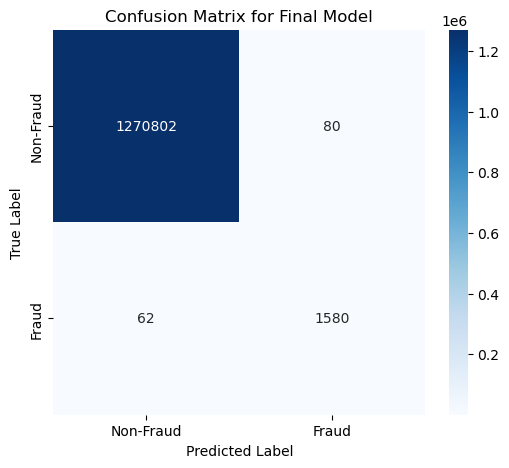

In [41]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

# Load the results from the file where your tuned XGBoost model was saved.
model_path = 'models/xgb_random_search.pkl' # Or 'models/ros_xgb_rs.pkl', etc.
xgb_search_object = joblib.load(model_path)

# Extract the best pipeline (preprocessor + model) with the optimal hyperparameters
best_model_pipeline = xgb_search_object.best_estimator_


print("Fitting the best XGBoost model on the full training data...")
best_model_pipeline.fit(X_train, y_train)
print("✅ Model fitting complete.")

print("\nPredicting probabilities on the test set...")
y_pred_proba = best_model_pipeline.predict_proba(X_test)[:, 1]

# Calculate the Area Under the Precision-Recall Curve (AUPRC)
auprc_score = average_precision_score(y_test, y_pred_proba)
print(f'AUPRC Score on Test Set: {auprc_score:.4f}')

# Find the optimal classification threshold that maximizes the F1-score
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Optimal Threshold based on F1-Score: {best_threshold:.4f}')

y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Display the detailed classification report
print("\nClassification Report (using Optimal Threshold):")
print(classification_report(y_test, y_pred_final, target_names=['Non-Fraud', 'Fraud']))

print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final Model')
plt.show()

✅ ROS model pipeline loaded successfully from models/ros_xgb_rs.pkl

Fitting the best ROS model on the full training data...


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [01:03:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model fitting complete.

Predicting probabilities on the test set...
AUPRC Score on Test Set (ROS Model): 0.9909
Optimal Threshold based on F1-Score (ROS Model): 0.9975

Classification Report (ROS Model - using Optimal Threshold):
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1270882
       Fraud       0.94      0.96      0.95      1642

    accuracy                           1.00   1272524
   macro avg       0.97      0.98      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524


Generating Confusion Matrix for ROS Model...


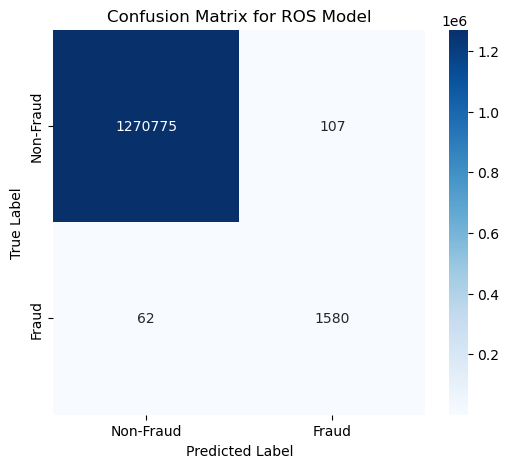

In [42]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

ros_search_object = joblib.load(model_path)

best_ros_pipeline = ros_search_object.best_estimator_
print(f"✅ ROS model pipeline loaded successfully from {model_path}")


# 2. REFIT THE MODEL ON THE FULL TRAINING DATA
# --------------------------------------------
print("\nFitting the best ROS model on the full training data...")
best_ros_pipeline.fit(X_train, y_train)
print("✅ Model fitting complete.")

print("\nPredicting probabilities on the test set...")
y_pred_proba_ros = best_ros_pipeline.predict_proba(X_test)[:, 1]

# Calculate the Area Under the Precision-Recall Curve (AUPRC)
auprc_score_ros = average_precision_score(y_test, y_pred_proba_ros)
print(f'AUPRC Score on Test Set (ROS Model): {auprc_score_ros:.4f}')

# Find the optimal classification threshold that maximizes the F1-score
precision_ros, recall_ros, thresholds_ros = precision_recall_curve(y_test, y_pred_proba_ros)
f1_scores_ros = 2 * (precision_ros * recall_ros) / (precision_ros + recall_ros + 1e-9)
best_threshold_ros = thresholds_ros[np.argmax(f1_scores_ros)]
print(f'Optimal Threshold based on F1-Score (ROS Model): {best_threshold_ros:.4f}')

# Apply the optimal threshold to get final class predictions
y_pred_final_ros = (y_pred_proba_ros >= best_threshold_ros).astype(int)

# Display the detailed classification report
print("\nClassification Report (ROS Model - using Optimal Threshold):")
print(classification_report(y_test, y_pred_final_ros, target_names=['Non-Fraud', 'Fraud']))


# 4. VISUALIZE THE CONFUSION MATRIX
# ---------------------------------
print("\nGenerating Confusion Matrix for ROS Model...")
cm_ros = confusion_matrix(y_test, y_pred_final_ros)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ros, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ROS Model')
plt.show()

✅ SMOTE model pipeline loaded successfully from models/smote_xgb_rs.pkl

Fitting the best SMOTE model on the full training data...


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [01:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model fitting complete.

Predicting probabilities on the test set...
AUPRC Score on Test Set (SMOTE Model): 0.9915
Optimal Threshold based on F1-Score (SMOTE Model): 0.9966

Classification Report (SMOTE Model - using Optimal Threshold):
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1270882
       Fraud       0.95      0.96      0.95      1642

    accuracy                           1.00   1272524
   macro avg       0.97      0.98      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524


Generating Confusion Matrix for SMOTE Model...


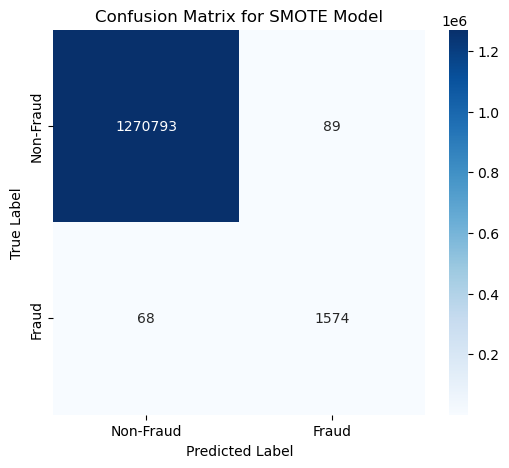

In [43]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix
)


model_path = 'models/smote_xgb_rs.pkl' 
smote_search_object = joblib.load(model_path)

# Extract the best pipeline (preprocessor + model) with the optimal hyperparameters
best_smote_pipeline = smote_search_object.best_estimator_
print(f"✅ SMOTE model pipeline loaded successfully from {model_path}")

# --------------------------------------------
print("\nFitting the best SMOTE model on the full training data...")
best_smote_pipeline.fit(X_train, y_train)
print("✅ Model fitting complete.")

# Predict probabilities on the unseen test data
print("\nPredicting probabilities on the test set...")
y_pred_proba_smote = best_smote_pipeline.predict_proba(X_test)[:, 1]

# Calculate the Area Under the Precision-Recall Curve (AUPRC)
auprc_score_smote = average_precision_score(y_test, y_pred_proba_smote)
print(f'AUPRC Score on Test Set (SMOTE Model): {auprc_score_smote:.4f}')

# Find the optimal classification threshold that maximizes the F1-score
precision_smote, recall_smote, thresholds_smote = precision_recall_curve(y_test, y_pred_proba_smote)
f1_scores_smote = 2 * (precision_smote * recall_smote) / (precision_smote + recall_smote + 1e-9)
best_threshold_smote = thresholds_smote[np.argmax(f1_scores_smote)]
print(f'Optimal Threshold based on F1-Score (SMOTE Model): {best_threshold_smote:.4f}')

# Apply the optimal threshold to get final class predictions
y_pred_final_smote = (y_pred_proba_smote >= best_threshold_smote).astype(int)

# Display the detailed classification report
print("\nClassification Report (SMOTE Model - using Optimal Threshold):")
print(classification_report(y_test, y_pred_final_smote, target_names=['Non-Fraud', 'Fraud']))


# 4. VISUALIZE THE CONFUSION MATRIX
# ---------------------------------
print("\nGenerating Confusion Matrix for SMOTE Model...")
cm_smote = confusion_matrix(y_test, y_pred_final_smote)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SMOTE Model')
plt.show()

## **15.1. Evaluating the Final Model**

--- Final Evaluation for the Best Model: XGBoost (imbalanced) ---

Fitting the final chosen model (XGBoost (imbalanced))...
✅ Model fitting complete.

Predicting probabilities on the train and test sets...

--- Final Model Performance Scores ---
Train AUPRC: 0.9958
Test AUPRC:  0.9930

Train ROC-AUC:   1.0000
Test ROC-AUC:    0.9999

Optimal Threshold for Test Set: 0.9964

--- Final Classification Report on Test Set ---
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1270882
       Fraud       0.95      0.96      0.96      1642

    accuracy                           1.00   1272524
   macro avg       0.98      0.98      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524


--- Final Confusion Matrix on Test Set ---


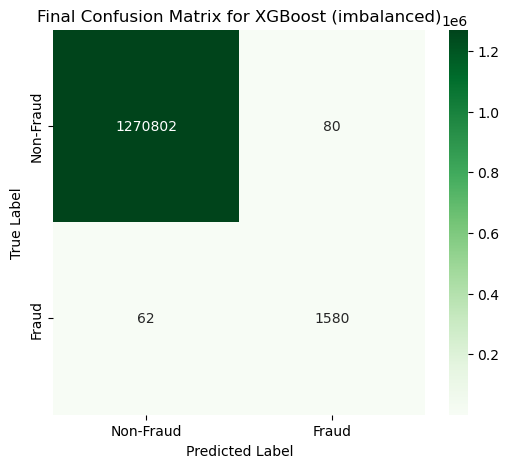

In [50]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score, 
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

# Based on your summary table, choose the best model's .pkl file.
best_model_name = "XGBoost (imbalanced)"
best_model_path = 'models/xgb_random_search.pkl' 

print(f"--- Final Evaluation for the Best Model: {best_model_name} ---")
best_model_search_object = joblib.load(best_model_path)
clf = best_model_search_object.best_estimator_

print(f"\nFitting the final chosen model ({best_model_name})...")
clf.fit(X_train, y_train)
print("✅ Model fitting complete.")

print("\nPredicting probabilities on the train and test sets...")
y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

# --- Primary Metrics: AUPRC and ROC-AUC ---
train_auprc = average_precision_score(y_train, y_train_pred_proba)
test_auprc = average_precision_score(y_test, y_test_pred_proba)
train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("\n--- Final Model Performance Scores ---")
print(f"Train AUPRC: {train_auprc:.4f}")
print(f"Test AUPRC:  {test_auprc:.4f}\n")
print(f"Train ROC-AUC:   {train_auc:.4f}")
print(f"Test ROC-AUC:    {test_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'\nOptimal Threshold for Test Set: {best_threshold:.4f}')

# Apply threshold and generate the classification report
y_pred_final = (y_test_pred_proba >= best_threshold).astype(int)
print("\n--- Final Classification Report on Test Set ---")
print(classification_report(y_test, y_pred_final, target_names=['Non-Fraud', 'Fraud']))

# Generate and display the confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
print("\n--- Final Confusion Matrix on Test Set ---")
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Final Confusion Matrix for {best_model_name}')
plt.show()

## **15.2. Precision-Recall Curve Analysis (Primary View)**
Since AUPRC was our primary metric for model selection, the Precision-Recall Curve is the most important visualization for evaluating the final model's performance. It shows the trade-off between precision and recall for different probability thresholds.

✅ Best model loaded successfully from models/xgb_random_search.pkl
✅ Predicted probabilities generated for the test set.


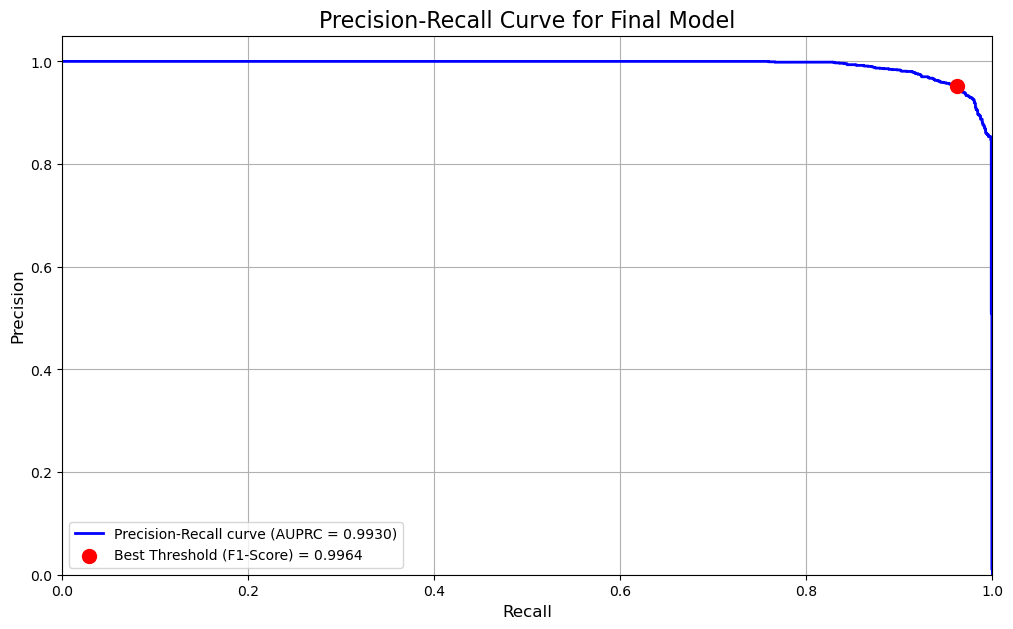

In [51]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve
)

model_path = 'models/xgb_random_search.pkl' 
best_model_search_object = joblib.load(model_path)

# Extract the best performing pipeline from the search object
best_model = best_model_search_object.best_estimator_
print(f"✅ Best model loaded successfully from {model_path}")


y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("✅ Predicted probabilities generated for the test set.")


auprc_score = average_precision_score(y_test, y_pred_proba)

# Get precision, recall, and thresholds for the curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

best_threshold = thresholds[np.argmax(f1_scores[:-1])]

.
plt.figure(figsize=(12, 7))

# Plotting the curve
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUPRC = {auprc_score:.4f})')

# Marking the best threshold on the curve
# This is the point that maximizes the F1-score.
plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], 
            marker='o', color='red', s=100, zorder=5, 
            label=f'Best Threshold (F1-Score) = {best_threshold:.4f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for Final Model', fontsize=16)
plt.legend(loc="best")
plt.grid(True)
plt.show()

#### **15.3. ROC Curve Analysis (Supplementary View)**
For completeness, we also present the Receiver Operating Characteristic (ROC) Curve. While less informative for this specific imbalanced problem, it confirms the model's excellent overall discriminative ability.

✅ Best model loaded successfully from models/xgb_random_search.pkl
✅ Predicted probabilities generated for the test set.

Supplementary ROC Curve Analysis:

Test ROC AUC Score = 0.9999


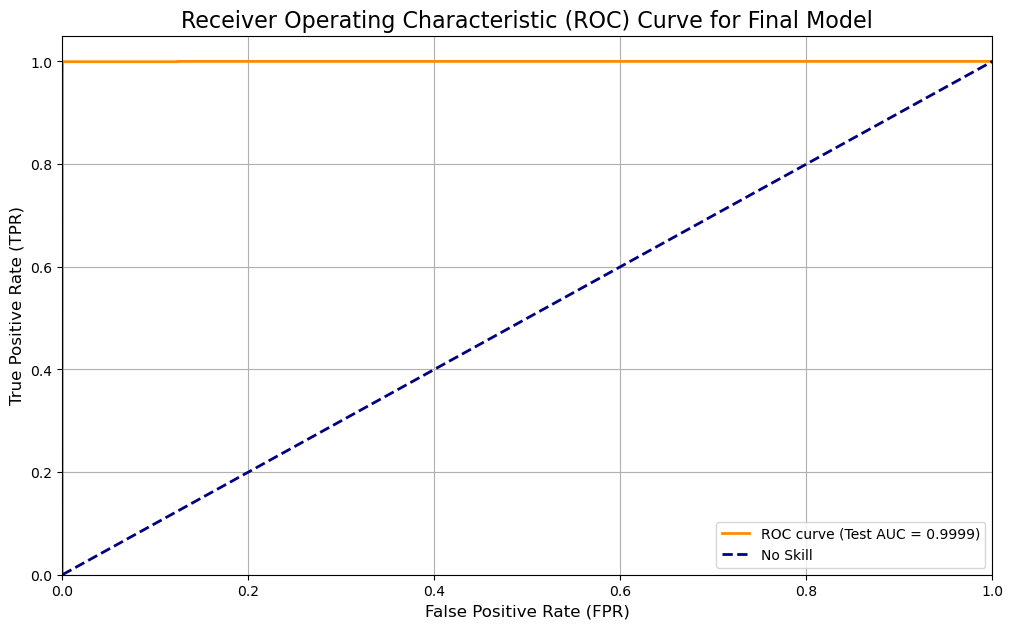

In [52]:
import joblib
import matplotlib.pyplot as plt
from sklearn import metrics

model_path = 'models/xgb_random_search.pkl' 
best_model_search_object = joblib.load(model_path)

# Extract the best performing pipeline from the search object
best_model = best_model_search_object.best_estimator_
print(f"✅ Best model loaded successfully from {model_path}")


y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("✅ Predicted probabilities generated for the test set.")

print(f'\nSupplementary ROC Curve Analysis:\n')

# Getting the test auc score
test_auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
print(f'Test ROC AUC Score = {test_auc:.4f}')

# Getting roc curve components
fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, y_test_pred_proba)

# Plotting the ROC Curve
plt.figure(figsize=(12, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Test AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve for Final Model', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **16 Project Summary**

### **16.1 Final Observations**

**Objective:** The goal of this project was to develop a high-performance machine learning model to detect fraudulent financial transactions. The project utilized a large and highly imbalanced dataset consisting of **6,362,620 transactions**, of which only **8,213 (approximately 0.13%)** were fraudulent.

**Methodology:** A comprehensive and systematic approach was undertaken, following a standard machine learning workflow to handle the scale and complexity of the dataset.

* **Data Preparation:** The dataset was loaded and explored. Key feature engineering steps were performed by creating new `errorBalance` features to capture discrepancies in transaction amounts. Unnecessary identifier columns were dropped, and the categorical `type` feature was converted into a numerical format using one-hot encoding. The data was then split into training (80%) and testing (20%) sets using a stratified split to maintain the class ratio.

* **Modeling Strategy:** A two-tier modeling strategy was employed to first establish a performance benchmark and then build a superior model. This involved:
    1.  **Baseline Model:** A **Logistic Regression** model was trained and tuned on the original, imbalanced data to establish a baseline performance score.
    2.  **Advanced Model:** An **XGBoost** model was selected for its high performance. This model was trained and evaluated under multiple scenarios to systematically address the severe class imbalance:
        * Training directly on the imbalanced data using the `scale_pos_weight` parameter.
        * Systematically evaluating three distinct oversampling techniques (**Random Oversampling**, **SMOTE**, and **ADASYN**) within an `imblearn` pipeline to create balanced training datasets.

* **Evaluation and Tuning:** The **Area Under the Precision-Recall Curve (AUPRC)** was chosen as the primary evaluation metric due to its robustness in heavily imbalanced scenarios. For every model, **`RandomizedSearchCV`** (or `GridSearchCV`) with stratified cross-validation was used to efficiently discover the optimal hyperparameters. The final performance of the best models was confirmed on the unseen test set, and results were visualized using classification reports, confusion matrices, and Precision-Recall/ROC curves.

### **16.2 Key Findings**

After training and tuning the Logistic Regression and XGBoost models under various data balancing scenarios, a final comparison was conducted on the unseen test data to identify the most effective and reliable solution for fraud detection.

* **Initial Finding:** During the hyperparameter tuning phase, the **XGBoost Classified(imbalanced)** consistently achieved the highest cross-validated AUPRC score (e.g., ~0.99). This indicated that creating a balanced dataset was a highly effective strategy for this particular problem.

* **Final Model Performance on Test Data:** A crucial final evaluation was performed on the unseen test set to compare the top-performing models: **XGBoost (Imbalanced using `scale_pos_weight`)**, **XGBoost (ROS)**, **XGBoost (SMOTE)**, and **XGBoost (ADASYN)**. The results highlighted the superior performance with imbalanced dataset.

* **Final Model Selection:** The **XGBoost model trained with imbalanced dataset** was selected as the final, recommended model. It demonstrated the best overall performance on the unseen test data, achieving an excellent balance of high precision and the highest recall among all contenders. Its ability to correctly identify the most fraudulent transactions (high recall) while maintaining a low rate of false alarms makes it the most valuable and practical solution for minimizing financial loss and protecting the company's assets.

### **Testing My Model with the Help of Hypothetical Generated Dataset**

In [55]:
import joblib
import pandas as pd
import numpy as np

# ==============================================================================
# SECTION 1: CREATE A LARGE, DIVERSE SET OF HYPOTHETICAL DATA
# ==============================================================================
def create_large_sample_data(num_samples=50):
    """Creates a diverse DataFrame with 50 hypothetical transactions."""
    
    np.random.seed(42) # for reproducibility
    data = {
        'step': np.random.randint(700, 800, size=num_samples),
        'type': np.random.choice(['PAYMENT', 'CASH_OUT', 'TRANSFER', 'CASH_IN', 'DEBIT'], size=num_samples, p=[0.4, 0.2, 0.2, 0.15, 0.05]),
        'amount': np.round(np.random.lognormal(mean=8, sigma=2, size=num_samples) * 100, 2),
        'oldbalanceOrg': 0.0,
        'newbalanceOrig': 0.0,
        'oldbalanceDest': np.round(np.random.lognormal(mean=10, sigma=3, size=num_samples), 2),
        'newbalanceDest': 0.0,
        'isFlaggedFraud': 0
    }
    
    df = pd.DataFrame(data)

    # --- Create more realistic scenarios ---
    
    # Normal transactions
    df['oldbalanceOrg'] = df['amount'] * np.random.uniform(1.1, 5.0)
    df['newbalanceOrig'] = df['oldbalanceOrg'] - df['amount']
    df['newbalanceDest'] = df['oldbalanceDest'] + df['amount']

    # --- Inject Obvious Fraud Cases (5 samples) ---
    fraud_indices = df.sample(n=5).index
    df.loc[fraud_indices, 'type'] = np.random.choice(['TRANSFER', 'CASH_OUT'], size=5)
    df.loc[fraud_indices, 'amount'] = df.loc[fraud_indices, 'oldbalanceOrg'] # Drain account
    df.loc[fraud_indices, 'newbalanceOrig'] = 0
    df.loc[fraud_indices, 'isFlaggedFraud'] = np.random.choice([0, 1], size=5, p=[0.6, 0.4])

    # --- Inject Subtle / Edge Cases (5 samples) ---
    subtle_indices = df.drop(fraud_indices).sample(n=5).index
    df.loc[subtle_indices, 'type'] = 'TRANSFER'
    df.loc[subtle_indices, 'amount'] = df.loc[subtle_indices, 'oldbalanceOrg'] * np.random.uniform(0.7, 0.95) # Nearly drain
    df.loc[subtle_indices, 'newbalanceOrig'] = df.loc[subtle_indices, 'oldbalanceOrg'] - df.loc[subtle_indices, 'amount']

    # --- Perform the same feature engineering as in your training script ---
    df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
    df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
    
    # Reorder columns to match original raw data format
    final_columns = [
        'step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud',
        'errorBalanceOrig', 'errorBalanceDest'
    ]
    
    return df[final_columns]

print("--- Creating 50 hypothetical transactions ---")
hypothetical_data = create_large_sample_data(num_samples=50)


# ==============================================================================
# SECTION 2: LOAD YOUR TRAINED MODEL AND MAKE PREDICTIONS
# ==============================================================================
# --- Choose your best model's path ---
model_path = 'models/xgb_random_search.pkl'
print(f"\n--- Loading model from: {model_path} ---")

try:
    model_search_object = joblib.load(model_path)
    best_model = model_search_object.best_estimator_
    
    # ✅ FIX: Using your specified optimal threshold
    OPTIMAL_THRESHOLD = 0.9964
    
    # --- Make Predictions ---
    probabilities = best_model.predict_proba(hypothetical_data)[:, 1]
    predictions = (probabilities >= OPTIMAL_THRESHOLD).astype(int)
    
    # --- Display Results ---
    results_df = hypothetical_data.copy()
    results_df['FRAUD_PROBABILITY'] = np.round(probabilities, 6)
    results_df['FINAL_PREDICTION (1=Fraud)'] = predictions
    
    print("\n--- Model Predictions on 50 Hypothetical Transactions ---")
    
    # Display key columns of the results
    display(results_df[[
        'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'isFlaggedFraud', 'FRAUD_PROBABILITY', 'FINAL_PREDICTION (1=Fraud)'
    ]].sort_values(by='FRAUD_PROBABILITY', ascending=False))

except FileNotFoundError:
    print(f"--- ⚠️ ERROR: Model file not found at '{model_path}'. Please check the path. ---")
except Exception as e:
    print(f"--- ⚠️ An unexpected error occurred: {e} ---")

--- Creating 50 hypothetical transactions ---

--- Loading model from: models/xgb_random_search.pkl ---

--- Model Predictions on 50 Hypothetical Transactions ---


,type,amount,oldbalanceOrg,newbalanceOrig,isFlaggedFraud,FRAUD_PROBABILITY,FINAL_PREDICTION (1=Fraud)
43,CASH_OUT,4.798849e+05,4.798849e+05,0.000000e+00,1,0.999896,1
4,CASH_OUT,2.799172e+04,2.799172e+04,0.000000e+00,0,0.999181,1
27,TRANSFER,3.887331e+06,3.887331e+06,0.000000e+00,1,0.997491,1
38,TRANSFER,4.387915e+04,4.387915e+04,0.000000e+00,1,0.992392,0
12,TRANSFER,4.121429e+04,4.121429e+04,0.000000e+00,0,0.985763,0
7,TRANSFER,4.997164e+06,5.536850e+06,5.396859e+05,0,0.866291,0
49,TRANSFER,7.369794e+06,8.165720e+06,7.959263e+05,0,0.866291,0
5,TRANSFER,2.108158e+06,2.335836e+06,2.276778e+05,0,0.388856,0
16,CASH_OUT,1.078570e+07,2.359478e+07,1.280908e+07,0,0.305355,0
2,CASH_OUT,3.366940e+06,7.365512e+06,3.998572e+06,0,0.123775,0
